In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import hdbscan
import sklearn.cluster as cluster

import napari

from scipy import stats
from skimage.filters import threshold_li, threshold_otsu

import tifffile

In [17]:
##### reading necessary files ####

M = pd.read_csv('/Volumes/liu/HippoVisualization/Umap120hippo.csv',header=None,)
Cell = pd.read_csv('/Volumes/liu/HippoVisualization/hippoCoM.csv',header=None,)
annot = pd.read_csv("./Hippo120_dlk.csv",header=None)[1]

print('M: row=cell,col=genes matrix:',M.shape)
print('Cell: XYZ space coordinate of cells:',Cell.shape)
print('annot: gene names:',annot.shape)

M: row=cell,col=genes matrix: (19871, 120)
Cell: XYZ space coordinate of cells: (19871, 3)
annot: gene names: (120,)


In [19]:
######### three input files into one matrix #######
M.columns = annot ### label columns with genes
Cell.columns = ['x','y','z']
m = pd.concat([M,Cell],axis=1) ### add xyz to the matrix
print(m.shape)
m.columns = m.columns.str.replace('\'','') # remove '' from columns names
m

(19871, 123)


,Egr1,Fos,Arc,Tiam1,Ptgs2,Homer1,Spock1,St8sia5,Tgfb2,Sgk1,...,Adgra1,Grm1,Erbb4,Adora1,Dlk1,S1pr1,Dlk1_1,x,y,z
0,0,1,1,0,1,1,0,2,1,0,...,3,0,2,2,0,1,1,1183.804717,458.685744,10.371141
1,1,0,1,1,0,0,0,1,1,1,...,0,0,1,0,0,1,0,1217.607923,511.970856,11.680783
2,2,1,1,0,1,2,0,1,1,0,...,4,1,4,3,1,5,3,1285.660597,548.370069,13.838524
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1126.445389,555.005819,10.599821
4,1,1,1,0,1,1,0,2,2,0,...,3,0,1,2,0,1,1,1157.884907,608.468298,10.706409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19866,0,0,0,0,0,3,0,0,0,0,...,6,0,2,7,0,6,6,3785.655154,1225.522240,106.051282
19867,0,0,0,0,0,3,0,0,0,0,...,6,0,2,5,0,1,6,3932.259687,1037.076669,105.089035
19868,0,0,0,0,0,6,0,0,0,0,...,16,0,2,22,0,0,22,3941.674599,1062.569356,105.942542
19869,0,0,0,0,1,0,0,0,0,0,...,6,1,3,6,1,3,7,3890.459474,1161.030059,106.836822


(120,)
min sum spots per gene:  12386.203363916919
genes removed:  59
min sum spots per cell:  10
cells removed:  1484


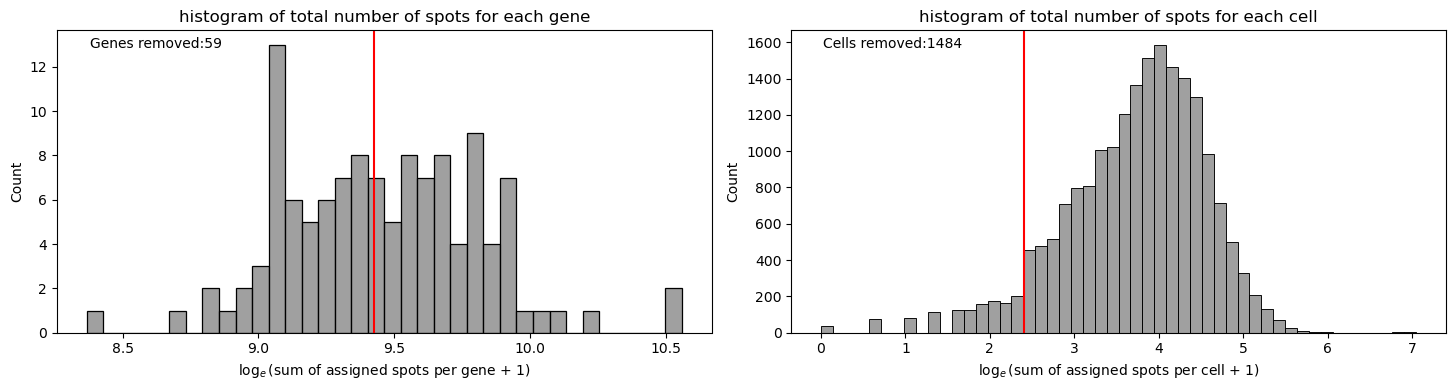

In [22]:
f = plt.figure(figsize=(22, 4))

ax0 = f.add_subplot(1,3,1)
ax1 = f.add_subplot(1,3,2)

########################## thresholding genes with low counts ###############################
dat = m.iloc[:,:-3]
x0 = np.log1p(np.sum(dat,axis=0).to_numpy()) #### sum per gene, in log space
print(x0.shape)

##### li threshold based on histogram ####
thresh_g = threshold_li(x0)
##### plot histogram and the threshold ####
h0 = sns.histplot(ax=ax0,data=x0,bins=36,color='grey')
h0.axvline(thresh_g,color='red')
g_removed = np.sum(x0<=thresh_g) ### number of genes removed
##### axis labeling ####
ax0.text(ax0.get_xlim()[0]+(ax0.get_xlim()[1]-ax0.get_xlim()[0])*0.05, ax0.get_ylim()[1]*0.94, 'Genes removed:'+str(g_removed)) # print the values on the histogram
ax0.set_title('histogram of total number of spots for each gene')
ax0.set_xlabel('$\log_{e}$(sum of assigned spots per gene + 1)')

##### print threshold in linear space and the number of genes removed #####
print('min sum spots per gene: ',np.expm1(thresh_g))
print('genes removed: ', str(g_removed))

############################################################################################

########################## thresholding cells with low counts ###############################
dat_rm_genes = dat.iloc[:,~(x0<=thresh_g)]
x1 = np.log1p(np.sum(dat_rm_genes,axis=1).to_numpy()) #### sum per cell, in log space


thresh_c = 10 #### arbitrarily chosen, results in < 5% cells being removed, value in linear space
c_removed = np.sum(x1<=np.log1p(thresh_c))
##### plot histogram and the threshold ####
h1 = sns.histplot(ax=ax1,data=x1,bins=50,color='grey')
h1.axvline(np.log1p(thresh_c),color='red')

##### axis labeling #####
ax1.text(ax1.get_xlim()[1]*0.05+ax1.get_xlim()[0], ax1.get_ylim()[1]*0.94, 'Cells removed:'+str(c_removed)) # print the values on the histogram
ax1.set_title('histogram of total number of spots for each cell')
ax1.set_xlabel('$\log_{e}$(sum of assigned spots per cell + 1)')

##### print threshold and the number of cells removed #####


print('min sum spots per cell: ',thresh_c)
print('cells removed: ', str(c_removed))

plt.tight_layout()

In [25]:
f.savefig("./hippo_umap_notebook/Hippo_histogram_v1.pdf",dpi=300, bbox_inches='tight')

In [32]:
def filter_matrix_hippo(m_xyz_df, tcell, tgene, norm=False, ForAssignment=False):
    mx = m_xyz_df.iloc[:,:-3]
    mcell = m_xyz_df[['x','y','z']]
    
    
    ### genes with low counts ####
    gene_rm = np.sum(mx,axis=0)<=tgene
    # print(mx.columns[gene_rm])
    print('removed gene count:', str(np.sum(gene_rm)))        
    
    ### remove genes ##
    mx_filter_gene = mx.iloc[:,~gene_rm.values]

    # cells with low count #
    cell_rm = np.sum(mx_filter_gene,axis=1)<=tcell   # threshold cells after removing genes
    mx_filter = mx_filter_gene.iloc[~cell_rm.values,:]
    print('removed cell count:', str(np.sum(cell_rm)))
    ##### normalize ####
    if ForAssignment==True:
        mx_filter = mx.iloc[~cell_rm.values,:]
        print('no gene removed')  # if true, remove no gene, in case we want to do some other analysis with them
    
    if norm==True:
        mx_norm = mx_filter.div(mx_filter.sum(axis=1), axis=0)*10_000
    else:
        mx_norm = mx_filter
    #######################
    mcell_filter = mcell.iloc[~cell_rm.values,:]
    o = pd.concat([mx_norm,mcell_filter],axis=1).reset_index(drop=True)
    
    # we will keep 4 things
    # 1. filtered matrix, with reset index
    # 2. boolean of kept cells in original index
    # 3. indices of kept cells (=npwhere.boolean of 2)
    # 4. indices of removed cells
    return o.reset_index(drop=True), (~cell_rm.values), np.where((~cell_rm.values))[0], np.where((cell_rm.values))[0]

Thresh_gene = np.expm1(thresh_g) #### thresh_g is in log space, so revert back to linear space
Thresh_cell = 10    #### 

m_filter,mfilter_boolcell,m_filter_ind,m_filter_indnull = filter_matrix_hippo(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=False,ForAssignment=False)

removed gene count: 59
removed cell count: 1484


In [51]:
##### new one ########
# pick a good looking umap cluster #
# see UMAP homepage for details about parameters

N = 200    ## n_neighbors 
C = 320    ## cluster size
S = 18   ## sample size


t_mat = m_filter.iloc[:,:-3]  ## we will use filtered matrix, remove the last three columns which are xyz space coordinates
embedding = umap.UMAP(random_state=42,min_dist=0, n_neighbors=N,n_components=2).fit_transform(t_mat)
labels = hdbscan.HDBSCAN(min_cluster_size=C,min_samples=S).fit_predict(embedding) ## call clusters on umap

print(embedding.shape,labels.shape, np.unique(labels))
# embedding is UMAP space x,y for retained cells
# labels is label of clusters, ranges from -1 to 5, 
# where -1 indicates 'unclustered', and 0 to 5 are assigned cluster

/opt/anaconda3/envs/napari_bigstream_umap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(18387, 2) (18387,) [-1  0  1  2  3  4  5]


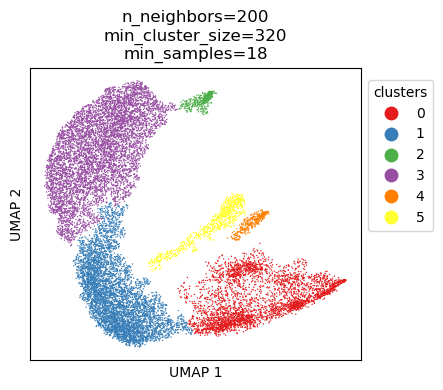

In [93]:
##### take a quick look at the umap ####
f = plt.figure(figsize=(8, 4))

embedding_labels = pd.DataFrame(embedding,columns=['UMAP 1','UMAP 2'])
embedding_labels['clusters'] = labels

#### label clusters ####
B = embedding_labels.clusters >= 0 ## only look at clustered cells
d = embedding_labels.loc[B,:].copy()

#### plot ####
ax = f.add_subplot(1,2,1)
a = sns.scatterplot(ax=ax,x='UMAP 1',y='UMAP 2',data=d,hue='clusters',palette='Set1',s=1,linewidth=0)

a.set_xticks([])
a.set_yticks([])  
a.set_xlabel('UMAP 1')
a.set_ylabel('UMAP 2')

a.set_title(
    'n_neighbors='+str(N)+
    '\nmin_cluster_size='+str(C)+
    '\nmin_samples='+str(S)
)
a.legend(loc='center left', bbox_to_anchor=(1, 0.7),title='clusters', markerscale=10)

plt.tight_layout()
plt.show() 

In [95]:
#### we will save a csv containing all cells ###

## dataframe containing filtered cells and their clusters ##
embedding_labels = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
embedding_labels['clusters'] = labels
embedding_labels['Cell_Index'] = m_filter_ind

## make a dataframe that mimics embedding_labels for removed cells ##
N_rm = len(m_filter_indnull) # number of removed cells
cells_rm_data = {'clusters': [-2]*N_rm,  # we will give these cells -2 value
                 'Cell_Index':m_filter_indnull
                } # note that there is no UMAP columns, because these cells were filetered BEFORE UMAP computation
Cells_rm_df = pd.DataFrame(data=cells_rm_data)

# merge two dataframe and save, UMAP1,2 for cells_rm_data will be filled with nan, since no such column
embedding_labels_all = pd.concat([embedding_labels,Cells_rm_df],axis=0).set_index('Cell_Index').sort_index()

## save as csv ##
#embedding_labels_all.to_csv('./hippo_umap_notebook/li_hippo_min10_neighbor200_c320_s18_UMAP_labels_allCells.csv',
#                            header=None,index=None)


In [2]:
#### reading above csv allows us to having to compute UMAP everytime ####
embedding_labels = pd.read_csv('./hippo_umap_notebook/li_hippo_min10_neighbor200_c320_s18_UMAP_labels_allCells.csv',header=None)
embedding_labels.columns = embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters']
embedding_labels

,UMAP 1,UMAP 2,clusters
0,-4.682667,-9.564777,0
1,-7.041329,-10.075299,1
2,-2.723285,-9.214541,0
3,NaN,NaN,-2
4,-4.345262,-9.829714,0
...,...,...,...
19866,-3.345637,-9.640426,0
19867,-6.171755,-9.938703,1
19868,-4.174903,-9.987666,0
19869,-3.900335,-9.886765,0


In [3]:
####### completely unnecessary, doing some cluster number swaps #####

bool_0 = embedding_labels.clusters == 2
bool_1 = embedding_labels.clusters == 5
bool_2 = embedding_labels.clusters == 4
bool_3 = embedding_labels.clusters == 3
bool_4 = embedding_labels.clusters == 0
bool_5 = embedding_labels.clusters == 1

embedding_labels['clusters_swap'] = embedding_labels['clusters'] # copy -1,-2, they do not change
embedding_labels.loc[bool_0,'clusters_swap'] = 0
embedding_labels.loc[bool_1,'clusters_swap'] = 1
embedding_labels.loc[bool_2,'clusters_swap'] = 2
embedding_labels.loc[bool_3,'clusters_swap'] = 3
embedding_labels.loc[bool_4,'clusters_swap'] = 4
embedding_labels.loc[bool_5,'clusters_swap'] = 5


In [4]:
##### our own colormap #####
## RGB alpha ##
my_COLORS = [(90/255,157/255,98/255,1),(188/255,8/255,71/255,1),(231/255,187/255,51/255,1),(230/255,111/255,214/255,242/255),(56/255,161/255,217/255,1),(53/255,1,1,1)]


[427, 879, 382, 6272, 3375, 5356] [1 2 3 4 5 6]
16.0


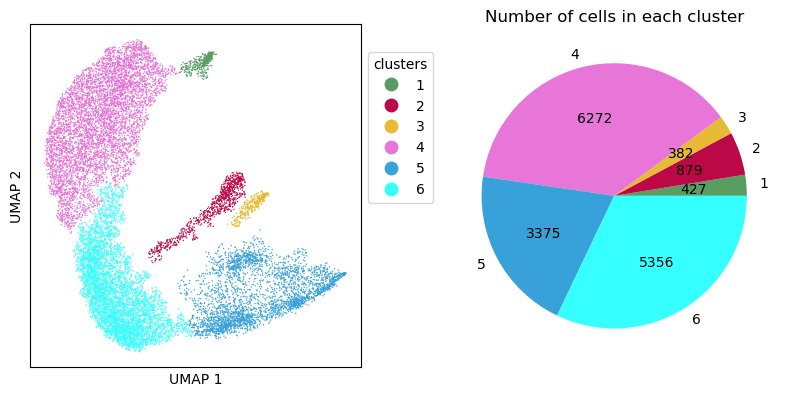

In [5]:
##### take a quick look at the umap ####
f = plt.figure(figsize=(8, 4))


labels = embedding_labels.clusters_swap
clusters = labels>=0

#### label clusters ####
d = embedding_labels.loc[clusters,:].copy()
d['clusters_swap'] = labels[clusters]+1


#### plot ####
ax = f.add_subplot(1,2,1)
a = sns.scatterplot(ax=ax,x='UMAP 1',y='UMAP 2',data=d,hue='clusters_swap',palette=my_COLORS,s=1,linewidth=0)

a.set_xticks([])
a.set_yticks([])  
a.set_xlabel('UMAP 1')
a.set_ylabel('UMAP 2')

a.legend(loc='center left', bbox_to_anchor=(1, 0.7),title='clusters', markerscale=10)



ax1 = f.add_subplot(1,2,2)

# declaring data 
nCells = []
for i in np.unique(labels[clusters]):
    nCells.append(np.sum(labels[clusters] == i))
    
keys = np.unique(d.clusters_swap)
print(nCells,keys)

  
# define Seaborn color palette to use 
palette_color = sns.color_palette(my_COLORS) 

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

# plotting data on chart 
_, _, autotexts = ax1.pie(nCells, labels=keys, colors=my_COLORS, autopct=autopct_format(nCells)) 
pie_txt = ['black','black','black','black','black','black']
for i in range(len(autotexts)):
    autotext = autotexts[i]
    autotext.set_color(pie_txt[i])
ax1.set_title('Number of cells in each cluster')

unclustered = round(sum(labels<0)/len(labels)*100,2)
print(unclustered)


plt.tight_layout()
plt.show() 

In [8]:
f.savefig("./hippo_umap_notebook/Hippo_UMAP.pdf",dpi=300, bbox_inches='tight')

In [6]:
### we will once again save swapped clusters for later work ####
#embedding_labels.to_csv('./hippo_umap_notebook/li_hippo_min10_neighbor200_c320_s18_UMAP_labels_allCells_clusterswap.csv',header=None,index=None)


In [9]:
embedding_labels = pd.read_csv('./hippo_umap_notebook/li_hippo_min10_neighbor200_c320_s18_UMAP_labels_allCells_clusterswap.csv',header=None)
embedding_labels.columns = embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters','clusters_swap']
embedding_labels

,UMAP 1,UMAP 2,clusters,clusters_swap
0,-4.682667,-9.564777,0,4
1,-7.041329,-10.075299,1,5
2,-2.723285,-9.214541,0,4
3,NaN,NaN,-2,-2
4,-4.345262,-9.829714,0,4
...,...,...,...,...
19866,-3.345637,-9.640426,0,4
19867,-6.171755,-9.938703,1,5
19868,-4.174903,-9.987666,0,4
19869,-3.900335,-9.886765,0,4


In [11]:
########### anatomical visualization ###############
### for napari ###
#### segmentation data ####
# not necessary but gives structure to visualization #
seg = tifffile.imread('/_Hippo_output_v1/HippoSegFinal.tiff')
seg[seg>0] = 1000  # segmentation data has different non-zero value for different cells, just turn them all to 1000
print('z,y,x:',seg.shape) # note that tifffile is read in z-y-x, see tifffile for more details on the format

Cell = pd.read_csv('/_Hippo_output_v1/hippoCoM.csv',header=None,) ## this is the Center of mass of segmentation mask


z,y,x: (109, 2178, 4076)


In [17]:
###### napari view ######

cluster_uniq = np.unique(embedding_labels.clusters_swap)[2:] ### clusters exclude -1,-2 (first two)
print(cluster_uniq)
s = 14 # blob size

########################### lots of clusters

#viewer = napari.view_points([b],face_color='black', size=s, name='unclustered', n_dimensional=True)
viewer = napari.view_image(seg,name='seg',)
viewer.theme = 'light'
COORD = Cell[[2,1,0]]   ### plot zyx to match the segmentation tiff

for c in cluster_uniq:
    COLOR = np.array(my_COLORS[c])
    print(COLOR)
    cluster_bool = labels==c
    viewer.add_points(COORD[cluster_bool], face_color=COLOR, size=s, name=str(c+1),n_dimensional=True,shading='spherical')
    

[0 1 2 3 4 5]
[0.35294118 0.61568627 0.38431373 1.        ]
[0.7372549  0.03137255 0.27843137 1.        ]
[0.90588235 0.73333333 0.2        1.        ]
[0.90196078 0.43529412 0.83921569 0.94901961]
[0.21960784 0.63137255 0.85098039 1.        ]
[0.20784314 1.         1.         1.        ]


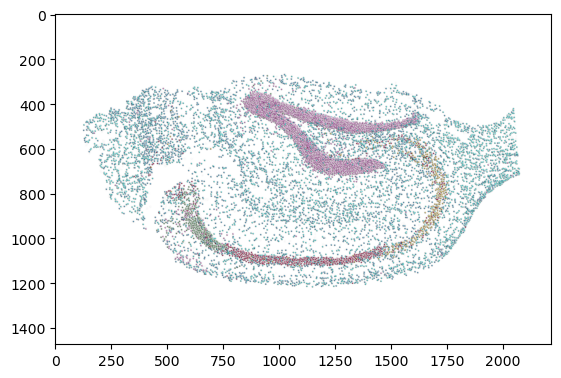

In [18]:
screenshot = viewer.screenshot()
plt.imshow(screenshot)